# Filtering and Thresholding Design Parameters and Broadband Objective Functions

While cheap gradients are always appreciated, we may have noticed that the optimizer and adjoint solver often produce devices that are impossible to fabricate. They tend to contain continuosly varying refractive indices or small feature sizes. Furthermore, the lack of constraint often throws the optimizer into local minima, stunting the overall progress of the solver.

To overcome this, the Topology Optimization (TO) community often implements linear and nonlinear functional transforms on the design parameters before projecting them onto the simulation domain. For example, we can blur many of the small design parameters together using a gaussian filter, and subsequently threshold using sigmoid like functions.

The resulting parameters can include constraints, like minimum lengths scales, and project the cost function into a more friendly (and sometimes less friendly) design space.

We'll examine how to accomplish these goals using native `autograd` functions and meep's adjoint solver.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import nlopt
from matplotlib import pyplot as plt
from scipy import special, signal
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


Let's choose our basic geometry paramters, along with the frequency range to simulate. If our frequency points are too close together than the resulting adjoint simulation may take longer to simulate each iteration.

In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5

waveguide_length = 0.5

pml_size = 1.0

resolution = 20

Si = 3.4777
SiO2 = 1.4440

frequencies = 1/np.linspace(1.5,1.6,10)

Now we'll specify our smoothing filter radius (in microns). We also need to specify the number of design parameters per meep pixel we want to set up.

In [3]:
filter_radius = 0.2
design_region_resolution = int(2.5*resolution)

As before, we'll generate our simulation cell with the specified sources, boundary layers, geometry, etc. Except this time, we'll randomly generate our design variables from 0 to 1 (rather than 1 to 12 as before).

In [4]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width
Sy = 2*pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,Sy,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24
np.random.seed(seed)
Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

Next, we'll define various filters that perform smoothing, projection, and material scaling. We'll be sure to use autograd so that we can easily backpropogate our gradient provided by the adjoint solver. We have some smoothing and thresholding filters already defined in the adjoint package that we'll use here.

In [5]:

def material_scaling(x):
    return (Si**2-SiO2**2)*x + SiO2**2
def mapping(x,sigma,delta,beta):
    #return material_scaling(x)
    return material_scaling(mpa.projection_filter(mpa.smoothing_filter(x,sigma,delta,Nx,Ny),sigma,delta,beta))

In [6]:
sigma = filter_radius * design_region_resolution # design parameter units
delta = 0
beta = 1

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = np.random.rand(Nx*Ny)
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=mapping(rho_vector,sigma,delta,beta))

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=Si), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=Si), size=mp.Vector3(waveguide_width,Sy/2+1, 0)), # top waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    default_material=mp.Medium(index=SiO2),
                    resolution=resolution)

Let's formulate our broadband objective function. To keep it simple we'll just minimize the sum of the error, where the error is the L2 norm between the transmission and 1 (i.e. the desired profile).

In [7]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3),size=mp.Vector3(y=Sy)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,Sx/2 - pml_size - 2*waveguide_length/3,0),size=mp.Vector3(x=Sx)),mode)
ob_list = [TE0,TE_top]
def J(source,top):
    desired = 1
    power = npa.abs(top/source)
    return npa.sum(npa.abs(power - desired) ** 2)

In [8]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_variables = [design_variables],
    frequencies=frequencies,
    decay_by = 1e-4,
    decay_fields=[mp.Ez]
)

Next, let's see how well our filtering and projection functions work.

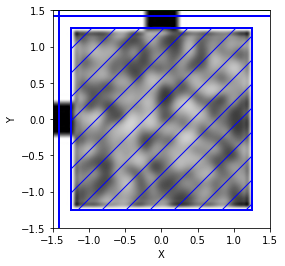

In [9]:
opt.update_design([mapping(rho_vector,4,0,8)])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()

We can increase our `beta` term, which controls the thresholding, and simultaneously sweep our perturbation term (`delta`) which is used to generate erosion and dilation geometries typically used in the literature. 

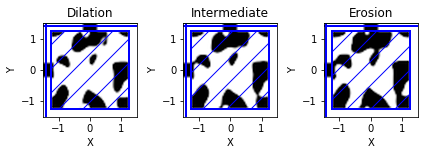

In [10]:
beta = 2048

plt.figure()
ax1 = plt.subplot(1,3,1)
opt.update_design([mapping(rho_vector,8,-0.01,beta)])
opt.plot2D(True,ax=ax1,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Dilation")

ax2 = plt.subplot(1,3,2)
opt.update_design([mapping(rho_vector,8,0,beta)])
opt.plot2D(True,ax=ax2,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Intermediate")

ax3 = plt.subplot(1,3,3)
opt.update_design([mapping(rho_vector,8,0.01,beta)])
opt.plot2D(True,ax=ax3,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.title("Erosion")

plt.tight_layout()
plt.show()

With our framwork in place, we can define our `nlopt` cost function wrapper that also includes our mapping layers and their corresponding gradients. We'll systematically increase our `beta` term so that the thresholding gradually turns on, as suggested by the literature.

In [11]:
evaluation_history = []
cur_iter = [0]
def f_simple(v, grad, cur_beta):
    print("Current iteration: {}/{}".format(cur_iter[0]+1,maxeval))
    
    f0, dJ_deps, dg = opt([mapping(v,sigma,delta,cur_beta)])
    
    if grad.size > 0:
        dJ_drhobar = np.sum(design_variables.get_basis_vjp(dJ_deps,dg),axis=1)  
        grad[:] = tensor_jacobian_product(mapping,0)(v,sigma,delta,cur_beta,dJ_drhobar)
    
    evaluation_history.append(np.max(np.real(f0)))
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

We now need to determine how often we will increase our thresholding parameter and how many total iterations we'll run.

In [12]:
update_factor = int(10)
beta_scale = 2
beta_start = beta_scale ** (-5)
maxeval=update_factor*15

We'll now run our optimizer in loop. The loop will increase beta and reset the optimizer, which is important since the cost function changes.

In [13]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
x0 = np.ones((Nx*Ny,)) * 0.5 #np.random.rand(Nx*Ny)
x = np.ones((Nx*Ny,)) * 0.0

cur_beta = beta_start
for iters in range(int(maxeval/update_factor)):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(0)
    solver.set_upper_bounds(1)
    solver.set_min_objective(lambda a,g: f_simple(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_xtol_rel(1e-4)
    x[:] = solver.optimize(x0)
    x0[:] = x
    cur_beta = cur_beta*beta_scale

[0.5 0.5 0.5 ... 0.5 0.5 0.5]
Current iteration: 1/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 2/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 3/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 4/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 5/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 6/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 7/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 8/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 9/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 10/150
Starting forward run...
Starting adjoint run...
Calculating gradient...

Starting adjoint run...
Calculating gradient...
Current iteration: 80/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
[0.08433553 0.08291462 0.07988152 ... 0.08236448 0.08454539 0.0849065 ]
Current iteration: 81/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 82/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 83/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 84/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 85/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 86/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 87/150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 88/150
Starting forward run...
Starting adjoint run...
Calculating gradient..

We'll wait for a few minutes (or longer) and visualize the results. We see that every time `beta` increases it either drives the cost function out of a local minimum or into a poorer spot. It gets harder to converge as `beta` increases. This is expected as the gradient starts to swing wildy at these thresholded transition regions. Regardless, we are still able to generate a somewhat smoothed structure after 150 iterations.

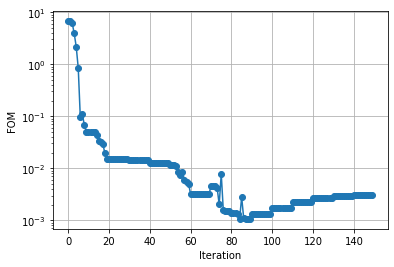

In [18]:
plt.figure()
plt.semilogy(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

To be sure, we can plot our results and see the resulting geometry.

/home/alechammond/miniconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


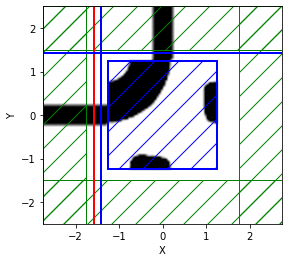

In [15]:
opt.update_design([mapping(x,sigma,delta,cur_beta)])
opt.plot2D(True)
plt.show()

Of course we want to check the final frequency response. We can run another forward run to pull the objective function parameters and calculate the transmisson.

In [16]:
f0, dJ_deps, dg = opt([mapping(x,sigma,delta,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2

Starting forward run...


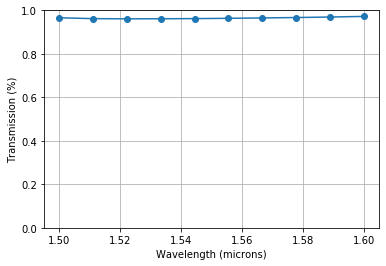

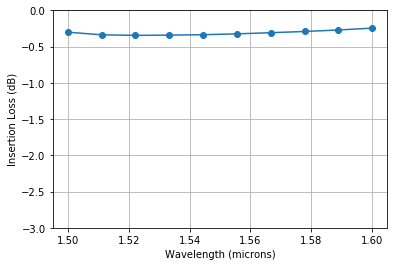

In [22]:
plt.figure()
plt.plot(1/frequencies,top_profile,'-o')
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transmission (%)')
plt.ylim(0,1)
plt.show()

plt.figure()
plt.plot(1/frequencies,20*np.log10(top_profile),'-o')
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion Loss (dB)')
plt.ylim(-3,0)
plt.show()

In summary, it is very easy to implement design constraints and density parameter operations using the native adjoint solver interface. One could use this same design flow to implement robus optimization over many frequency points.